# import os
import sys
sys.path.insert(0, os.path.abspath('../'))

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D as ax
import arrayfire as af

from dg_maxwell import params
from dg_maxwell import utils
from dg_maxwell import lagrange
from dg_maxwell import wave_equation_2d as w2d
from dg_maxwell import msh_parser
from dg_maxwell import isoparam

af.set_backend(params.backend)

In [2]:
N_LGL = 8
xi_LGL  = af.np_to_af_array(np.array(lagrange.LGL_points(N_LGL)))
eta_LGL = af.np_to_af_array(np.array(lagrange.LGL_points(N_LGL)))

Xi, Eta = utils.af_meshgrid(xi_LGL, eta_LGL)

eta = af.tile(eta_LGL, N_LGL)
xi = af.flat(af.transpose(af.tile(xi_LGL, 1, N_LGL)))

_, L_p = lagrange.lagrange_polynomials(xi_LGL)
_, L_q = lagrange.lagrange_polynomials(eta_LGL)

L_p = af.np_to_af_array(L_p)
L_q = af.np_to_af_array(L_q)

/home/bala/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1187: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/bala/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1214: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [3]:
dLp_dxi  = utils.polynomial_derivative(L_p)
dLq_deta = utils.polynomial_derivative(L_q)

In [4]:
nodes, elements = msh_parser.read_order_2_msh('read_and_plot_mesh/mesh/square.msh')

gmshTranslator: Initializing...
gmshTranslator: Mesh has 49 nodes.
gmshTranslator: Mesh has 25 elements.
gmshTranslator: Processed 78 lines.
gmshTranslator: There are 1 physical groups available: 
gmshTranslator:      > 0
gmshTranslator: Parsing nodes
gmshTranslator: Parsing elements
gmshTranslator: No rules for elements... skipping elements.
gmshTranslator: Parsing nodes
gmshTranslator: No rules for nodes... skipping nodes.
gmshTranslator: Parsing elements


In [5]:
def F_xi(u):
    '''
    '''
    dxi_dx  = w2d.dxi_dx(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi, eta)
    dxi_dy  = w2d.dxi_dy(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi, eta)
    
    return w2d.F_x(u) * dxi_dx + w2d.F_y(u) * dxi_dy

def F_eta(u):
    '''
    '''
    deta_dx = w2d.deta_dx(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi, eta)
    deta_dy = w2d.deta_dy(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi, eta)
    
    return w2d.F_x(u) * deta_dx + w2d.F_y(u) * deta_dy

gmshTranslator: Ending


In [6]:
def g_dd(x_nodes, y_nodes, xi, eta):
    '''
    '''
    ans00  =   (w2d.dx_dxi(x_nodes, xi, eta))**2 \
             + (w2d.dy_dxi(y_nodes, xi, eta))**2
    ans11  =   (w2d.dx_deta(x_nodes, xi, eta))**2 \
             + (w2d.dy_deta(y_nodes, xi, eta))**2
    
    ans01  =  (w2d.dx_dxi(x_nodes, xi, eta))  \
            * (w2d.dx_deta(x_nodes, xi, eta)) \
            + (w2d.dy_dxi(y_nodes, xi, eta))  \
            * (w2d.dy_deta(y_nodes, xi, eta))
    
    ans =  [[ans00, ans01],
            [ans01, ans11]
           ]
    
    return ans


def g_uu(x_nodes, y_nodes, xi, eta):
    gCov = g_dd(x_nodes, y_nodes, xi, eta)
    
    
    a = gCov[0][0]
    b = gCov[0][1]
    c = gCov[1][0]
    d = gCov[1][1]
    
    det = (a*d - b*c)
    
    ans = [[d / det, -b / det],
           [-c / det, a / det]]
    
    return ans


def sqrtgDet(x_nodes, y_nodes, xi, eta):
    '''
    '''
    gCov = g_dd(x_nodes, y_nodes, xi, eta)
    
    a = gCov[0][0]
    b = gCov[0][1]
    c = gCov[1][0]
    d = gCov[1][1]
    
    return (a*d - b*c)**0.5


In [7]:
g_ab = g_uu(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi, eta)

In [8]:
x = []
y = []

X = []
Y = []

u_init = []
u_init_mesh = []
F_xi_LGL  = []
F_eta_LGL = []
F_xi_LGL_mesh  = []
F_eta_LGL_mesh = []


for idx, element in enumerate(elements):
    x.append(af.np_to_af_array(isoparam.isoparam_x_2D(nodes[element][:, 0], np.array(Xi), np.array(Eta))))
    y.append(af.np_to_af_array(isoparam.isoparam_x_2D(nodes[element][:, 1], np.array(Xi), np.array(Eta))))

    X.append(af.np_to_af_array(isoparam.isoparam_x_2D(nodes[element][:, 0], np.array(Xi), np.array(Eta))))
    Y.append(af.np_to_af_array(isoparam.isoparam_x_2D(nodes[element][:, 1], np.array(Xi), np.array(Eta))))

    x[-1] = af.moddims(x[-1], d0 = N_LGL * N_LGL, d1 = 1)
    y[-1] = af.moddims(y[-1], d0 = N_LGL * N_LGL, d1 = 1)

    u_init.append(np.e ** (-(x[-1]**2 + y[-1]**2) / 0.4**2))
    u_init_mesh.append(af.np_to_af_array(np.array(af.moddims(u_init[-1], d0 = N_LGL, d1 = N_LGL)))) # Temporary numpy fix for the bug.
    
    F_xi_LGL.append(F_xi(u_init[idx]))
    F_eta_LGL.append(F_eta(u_init[idx]))
    
    F_xi_LGL_mesh.append(af.np_to_af_array(np.array(af.moddims(F_xi_LGL[-1], d0 = N_LGL, d1 = N_LGL))))
    F_eta_LGL_mesh.append(af.np_to_af_array(np.array(af.moddims(F_eta_LGL[-1], d0 = N_LGL, d1 = N_LGL))))


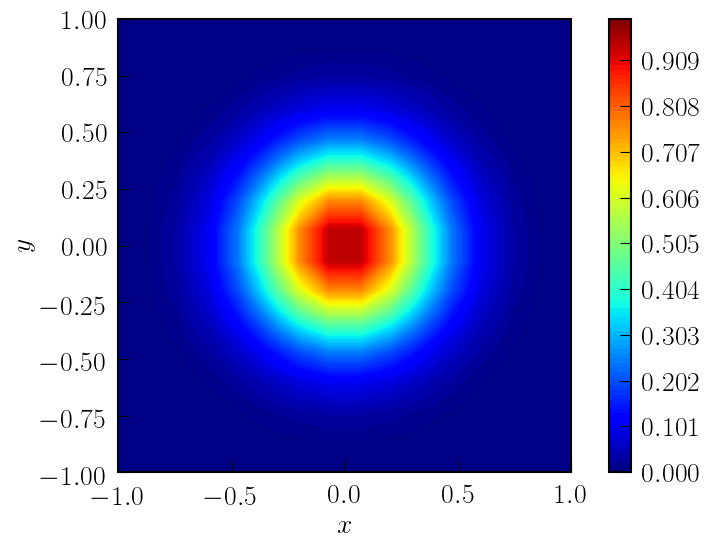

In [9]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
color_levels = np.linspace(0., 1., 100)

for idx in np.arange(len(u_init_mesh)):
#     ax.plot_surface(np.array(X[idx]), np.array(Y[idx]), np.array(u_init_mesh[idx]))
    plt.contourf(np.array(X[idx]), np.array(Y[idx]), np.array(u_init_mesh[idx]),
                 200, levels = color_levels, cmap = 'jet')

plt.axes().set_aspect('equal')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.colorbar()

# plt.savefig('u_init.png')
plt.show()

In [10]:
L_p_array = af.moddims(af.tile(af.transpose(af.reorder(L_p, d0 = 0, d1 = 2, d2 = 1)),
                               d0 = N_LGL), d0 = N_LGL * N_LGL, d1 = 1, d2 = N_LGL)
L_p_array = af.reorder(L_p_array, d0 = 0, d1 = 2, d2 = 1)

L_q_array = af.tile(L_p, d0 = N_LGL)

In [11]:
u_af = af.np_to_af_array(np.zeros([len(u_init_mesh), N_LGL, N_LGL]))

for idx, u in enumerate(u_init_mesh):
    u_af[idx] = af.reorder(u, d0 = 2, d1 = 0, d2 = 1)
    
u_af = af.np_to_af_array(np.array(u_af))

In [12]:
for idx in np.arange(len(u_init_mesh)):
    print(af.all_true(u_init_mesh[idx] - af.reorder(u_af[idx], d0 = 1, d1 = 2, d2 = 0) == 0))

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [13]:
u_af_grid = af.transpose(af.moddims(af.reorder(u_af, d0 = 0, d1 = 3, d2 = 1, d3 = 2), d0 = 3, d1 = 3, d2 = N_LGL, d3 = N_LGL))

In [14]:
print(af.all_true(u_init_mesh[0] - af.reorder(u_af_grid[0, 0], d0 = 2, d1 = 3, d2 = 1, d3 = 0) == 0))
print(af.all_true(u_init_mesh[1] - af.reorder(u_af_grid[0, 1], d0 = 2, d1 = 3, d2 = 1, d3 = 0) == 0))
print(af.all_true(u_init_mesh[2] - af.reorder(u_af_grid[0, 2], d0 = 2, d1 = 3, d2 = 1, d3 = 0) == 0))
print(af.all_true(u_init_mesh[3] - af.reorder(u_af_grid[1, 0], d0 = 2, d1 = 3, d2 = 1, d3 = 0) == 0))
print(af.all_true(u_init_mesh[4] - af.reorder(u_af_grid[1, 1], d0 = 2, d1 = 3, d2 = 1, d3 = 0) == 0))
print(af.all_true(u_init_mesh[5] - af.reorder(u_af_grid[1, 2], d0 = 2, d1 = 3, d2 = 1, d3 = 0) == 0))
print(af.all_true(u_init_mesh[6] - af.reorder(u_af_grid[2, 0], d0 = 2, d1 = 3, d2 = 1, d3 = 0) == 0))
print(af.all_true(u_init_mesh[7] - af.reorder(u_af_grid[2, 1], d0 = 2, d1 = 3, d2 = 1, d3 = 0) == 0))
print(af.all_true(u_init_mesh[8] - af.reorder(u_af_grid[2, 2], d0 = 2, d1 = 3, d2 = 1, d3 = 0) == 0))

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [15]:
print(u_af_grid[0, 0, :, 2])

arrayfire.Array()
Type: double

[1 1 8 1]
    0.0047 

    0.0039 

    0.0024 

    0.0010 

    0.0003 

    0.0001 

    0.0000 

    0.0000 





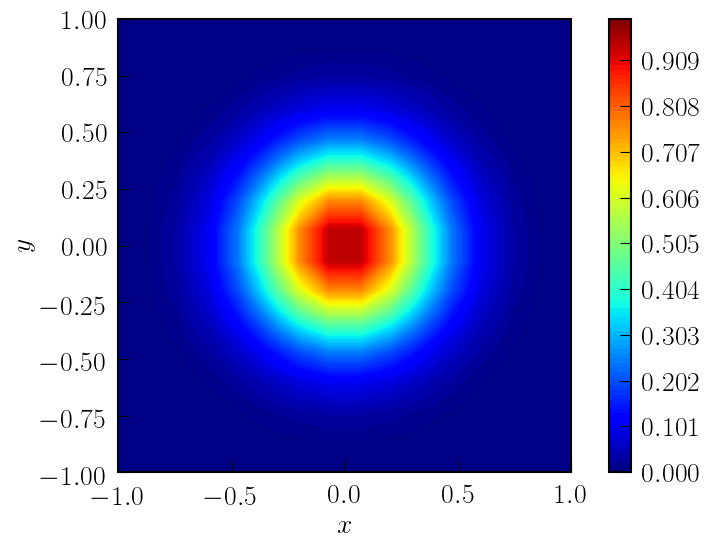

In [16]:
# plt.contourf(np.array(X[0]), np.array(Y[0]), np.array(af.reorder(u_af_grid[0, 0], 2, 3, 0, 1)),
#              200, levels = color_levels, cmap = 'jet')

plt.contourf(np.array(X[0]), np.array(Y[0]), np.array(af.reorder(u_af_grid[0, 0], 2, 3, 0, 1)), 200, levels = color_levels, cmap = 'jet')
plt.contourf(np.array(X[1]), np.array(Y[1]), np.array(af.reorder(u_af_grid[0, 1], 2, 3, 0, 1)), 200, levels = color_levels, cmap = 'jet')
plt.contourf(np.array(X[2]), np.array(Y[2]), np.array(af.reorder(u_af_grid[0, 2], 2, 3, 0, 1)), 200, levels = color_levels, cmap = 'jet')
plt.contourf(np.array(X[3]), np.array(Y[3]), np.array(af.reorder(u_af_grid[1, 0], 2, 3, 0, 1)), 200, levels = color_levels, cmap = 'jet')
plt.contourf(np.array(X[4]), np.array(Y[4]), np.array(af.reorder(u_af_grid[1, 1], 2, 3, 0, 1)), 200, levels = color_levels, cmap = 'jet')
plt.contourf(np.array(X[5]), np.array(Y[5]), np.array(af.reorder(u_af_grid[1, 2], 2, 3, 0, 1)), 200, levels = color_levels, cmap = 'jet')
plt.contourf(np.array(X[6]), np.array(Y[6]), np.array(af.reorder(u_af_grid[2, 0], 2, 3, 0, 1)), 200, levels = color_levels, cmap = 'jet')
plt.contourf(np.array(X[7]), np.array(Y[7]), np.array(af.reorder(u_af_grid[2, 1], 2, 3, 0, 1)), 200, levels = color_levels, cmap = 'jet')
plt.contourf(np.array(X[8]), np.array(Y[8]), np.array(af.reorder(u_af_grid[2, 2], 2, 3, 0, 1)), 200, levels = color_levels, cmap = 'jet')

plt.axes().set_aspect('equal')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.colorbar()

# plt.savefig('u_init.png')
plt.show()

In [17]:
u_vertical_boundary = []

for i in np.arange(u_af_grid.shape[0]):
    for j in np.arange(u_af_grid.shape[1]):
#         print(i, (j + 1) % 3, '->', end = '')
#         print(i, j)
        u_vertical_boundary.append([])
        u_vertical_boundary[-1].append(af.reorder((u_af_grid[i, (j + 1) % 3, :, 0] - u_af_grid[i, j, :, N_LGL - 1]) / 2,
                                                  d0 = 2, d1 = 1, d2 = 0))

# u_vertical_boundary[-1].append(af.reorder((u_af_grid[0, 1, :, 0] - u_af_grid[0, 0, :, N_LGL - 1]) / 2, d0 = 2, d1 = 1, d2 = 0))
# u_vertical_boundary[-1].append(af.reorder((u_af_grid[0, 2, :, 0] - u_af_grid[0, 1, :, N_LGL - 1]) / 2, d0 = 2, d1 = 1, d2 = 0))
# u_vertical_boundary[-1].append(af.reorder((u_af_grid[0, 0, :, 0] - u_af_grid[0, 2, :, N_LGL - 1]) / 2, d0 = 2, d1 = 1, d2 = 0))

# u_vertical_boundary.append([])
# u_vertical_boundary[-1].append(af.reorder((u_af_grid[1, 1, :, 0] - u_af_grid[1, 0, :, N_LGL - 1]) / 2, d0 = 2, d1 = 1, d2 = 0))
# u_vertical_boundary[-1].append(af.reorder((u_af_grid[1, 2, :, 0] - u_af_grid[1, 1, :, N_LGL - 1]) / 2, d0 = 2, d1 = 1, d2 = 0))
# u_vertical_boundary[-1].append(af.reorder((u_af_grid[1, 0, :, 0] - u_af_grid[1, 2, :, N_LGL - 1]) / 2, d0 = 2, d1 = 1, d2 = 0))

# u_vertical_boundary.append([])
# u_vertical_boundary[-1].append(af.reorder((u_af_grid[2, 1, :, 0] - u_af_grid[2, 0, :, N_LGL - 1]) / 2, d0 = 2, d1 = 1, d2 = 0))
# u_vertical_boundary[-1].append(af.reorder((u_af_grid[2, 2, :, 0] - u_af_grid[2, 1, :, N_LGL - 1]) / 2, d0 = 2, d1 = 1, d2 = 0))
# u_vertical_boundary[-1].append(af.reorder((u_af_grid[2, 0, :, 0] - u_af_grid[2, 2, :, N_LGL - 1]) / 2, d0 = 2, d1 = 1, d2 = 0))


In [18]:
u_horizontal_boundary = []

for i in np.arange(u_af_grid.shape[0]):
    for j in np.arange(u_af_grid.shape[1]):
        u_horizontal_boundary.append([])
        u_horizontal_boundary[-1].append(af.reorder((u_af_grid[(j + 1) % 3, i, N_LGL - 1, :] - u_af_grid[j, i, 0, :]) / 2,
                                                    d0 = 3, d1 = 1, d2 = 2, d3 = 0))

In [19]:
print(u_vertical_boundary)

[[arrayfire.Array()
Type: double
Dims: (8,)], [arrayfire.Array()
Type: double
Dims: (8,)], [arrayfire.Array()
Type: double
Dims: (8,)], [arrayfire.Array()
Type: double
Dims: (8,)], [arrayfire.Array()
Type: double
Dims: (8,)], [arrayfire.Array()
Type: double
Dims: (8,)], [arrayfire.Array()
Type: double
Dims: (8,)], [arrayfire.Array()
Type: double
Dims: (8,)], [arrayfire.Array()
Type: double
Dims: (8,)]]


In [20]:
for row in u_vertical_boundary:
    for u in row:
        af.display(u, 14)

In [21]:
print(F_xi_LGL_mesh[0])

arrayfire.Array()
Type: double

[8 8 1 1]
    0.0029     0.0049     0.0141     0.0505     0.1616     0.3779     0.6189     0.7481 
    0.0024     0.0040     0.0117     0.0418     0.1337     0.3126     0.5120     0.6189 
    0.0015     0.0025     0.0071     0.0255     0.0816     0.1909     0.3126     0.3779 
    0.0006     0.0011     0.0030     0.0109     0.0349     0.0816     0.1337     0.1616 
    0.0002     0.0003     0.0010     0.0034     0.0109     0.0255     0.0418     0.0505 
    0.0001     0.0001     0.0003     0.0010     0.0030     0.0071     0.0117     0.0141 
    0.0000     0.0000     0.0001     0.0003     0.0011     0.0025     0.0040     0.0049 
    0.0000     0.0000     0.0001     0.0002     0.0006     0.0015     0.0024     0.0029 




In [22]:
F_xi_af = af.np_to_af_array(np.zeros([len(F_xi_LGL_mesh), N_LGL, N_LGL]))

for idx, F in enumerate(F_xi_LGL_mesh):
    F_xi_af[idx] = af.reorder(F, d0 = 2, d1 = 0, d2 = 1)

F_xi_af = af.np_to_af_array(np.array(F_xi_af))
F_xi_af_grid = af.transpose(af.moddims(af.reorder(F_xi_af, d0 = 0, d1 = 3, d2 = 1, d3 = 2), d0 = 3, d1 = 3, d2 = N_LGL, d3 = N_LGL))
print(F_xi_af.shape)


F_eta_af = af.np_to_af_array(np.zeros([len(F_eta_LGL_mesh), N_LGL, N_LGL]))

for idx, F in enumerate(F_xi_LGL_mesh):
    F_eta_af[idx] = af.reorder(F, d0 = 2, d1 = 0, d2 = 1)

F_eta_af = af.np_to_af_array(np.array(F_eta_af))
F_eta_af_grid = af.transpose(af.moddims(af.reorder(F_eta_af, d0 = 0, d1 = 3, d2 = 1, d3 = 2), d0 = 3, d1 = 3, d2 = N_LGL, d3 = N_LGL))

(9, 8, 8)


In [23]:
print(af.reorder(F_eta_af[0, :, :], 1, 2, 0))

arrayfire.Array()
Type: double

[8 8 1 1]
    0.0029     0.0049     0.0141     0.0505     0.1616     0.3779     0.6189     0.7481 
    0.0024     0.0040     0.0117     0.0418     0.1337     0.3126     0.5120     0.6189 
    0.0015     0.0025     0.0071     0.0255     0.0816     0.1909     0.3126     0.3779 
    0.0006     0.0011     0.0030     0.0109     0.0349     0.0816     0.1337     0.1616 
    0.0002     0.0003     0.0010     0.0034     0.0109     0.0255     0.0418     0.0505 
    0.0001     0.0001     0.0003     0.0010     0.0030     0.0071     0.0117     0.0141 
    0.0000     0.0000     0.0001     0.0003     0.0011     0.0025     0.0040     0.0049 
    0.0000     0.0000     0.0001     0.0002     0.0006     0.0015     0.0024     0.0029 




In [24]:
F_eta_vertical_boundary = []

for i in np.arange(F_eta_af_grid.shape[0]):
    F_eta_vertical_boundary.append([])
    for j in np.arange(F_xi_af_grid.shape[1]):

        F_eta_vertical_boundary[-1].append(af.reorder((F_eta_af_grid[i, (j + 1) % 3, :, 0]\
                                                       + F_eta_af_grid[i, j, :, N_LGL - 1]) / 2,
                                                      d0 = 2, d1 = 1, d2 = 0))

In [25]:
F_xi_horizontal_boundary = []

for i in np.arange(F_xi_af_grid.shape[0]):
    F_xi_horizontal_boundary.append([])
    for j in np.arange(F_xi_af_grid.shape[1]):
        F_xi_horizontal_boundary[-1].append(af.reorder((F_xi_af_grid[(j + 1) % 3, i, N_LGL - 1, :]\
                                                        + F_xi_af_grid[j, i, 0, :]) / 2,
                                                       d0 = 3, d1 = 1, d2 = 2, d3 = 0))

In [26]:
f_horizontal = []
f_vertical   = []

for idx in np.arange(len(F_xi_horizontal_boundary)):
    f_horizontal.append(F_xi_horizontal_boundary[idx] + u_horizontal_boundary[idx])
    f_vertical.append(F_eta_vertical_boundary[idx] + u_vertical_boundary[idx])

In [27]:
print(f_vertical[0][0], F_xi(u_init[0])[-N_LGL:])

arrayfire.Array()
Type: double

[8 1 1 1]
    0.7481 
    0.6189 
    0.3779 
    0.1616 
    0.0505 
    0.0141 
    0.0049 
    0.0029 

 arrayfire.Array()
Type: double

[8 1 1 1]
    0.7481 
    0.6189 
    0.3779 
    0.1616 
    0.0505 
    0.0141 
    0.0049 
    0.0029 




In [28]:
print(f_vertical[-1][-2], F_xi(u_init[0]))

arrayfire.Array()
Type: double

[8 1 1 1]
    0.0000 
    0.0000 
    0.0001 
    0.0002 
    0.0006 
    0.0015 
    0.0024 
    0.0029 

 arrayfire.Array()
Type: double

[64 1 1 1]
    0.0029 
    0.0024 
    0.0015 
    0.0006 
    0.0002 
    0.0001 
    0.0000 
    0.0000 
    0.0049 
    0.0040 
    0.0025 
    0.0011 
    0.0003 
    0.0001 
    0.0000 
    0.0000 
    0.0141 
    0.0117 
    0.0071 
    0.0030 
    0.0010 
    0.0003 
    0.0001 
    0.0001 
    0.0505 
    0.0418 
    0.0255 
    0.0109 
    0.0034 
    0.0010 
    0.0003 
    0.0002 
    0.1616 
    0.1337 
    0.0816 
    0.0349 
    0.0109 
    0.0030 
    0.0011 
    0.0006 
    0.3779 
    0.3126 
    0.1909 
    0.0816 
    0.0255 
    0.0071 
    0.0025 
    0.0015 
    0.6189 
    0.5120 
    0.3126 
    0.1337 
    0.0418 
    0.0117 
    0.0040 
    0.0024 
    0.7481 
    0.6189 
    0.3779 
    0.1616 
    0.0505 
    0.0141 
    0.0049 
    0.0029 




In [29]:
lagrange_coeffs = params.lagrange_coeffs

In [30]:
af_f_vertical = af.np_to_af_array(np.zeros([N_LGL, 3, 3]))
for i in range(3):
    for j in range(3):
        af_f_vertical[:, i, j] = f_vertical[i][j]

af_f_horizontal = af.np_to_af_array(np.zeros([N_LGL, 3, 3]))
for i in range(3):
    for j in range(3):
        af_f_horizontal[:, i, j] = f_horizontal[i][j]

In [31]:
# Surface term for xi = 1
surface_term_xi_1_boundary = af.np_to_af_array(np.zeros([N_LGL ** 2, 9]))
for i in range(3):
    for j in range(3):
        L_q_eta_F_1_eta_coeffs  = (af.broadcast(utils.multiply, af_f_vertical[:, i, j], lagrange_coeffs))
        int_Lq_eta_F_1_eta_g_00 = lagrange.integrate(L_q_eta_F_1_eta_coeffs) * af.mean(g_ab[0][0])
        surface_term_xi_1       = af.np_to_af_array(np.zeros([N_LGL ** 2]))

        surface_term_xi_1[-N_LGL:] = int_Lq_eta_F_1_eta_g_00
        surface_term_xi_1_boundary[:, 3 * i + j] = surface_term_xi_1


#L_q_eta_F_minus1_eta_coeffs = af.broadcast(utils.multiply, )
print(surface_term_xi_1_boundary)

arrayfire.Array()
Type: double

[64 9 1 1]
    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
    0.0000     0.0000     0.0000     0.0000     0.0000   

In [32]:
# surface term for xi= -1 boundary

af_f_vertical_xi_minus1 = af.shift(af_f_vertical, d0=0, d1=0, d2=1)

surface_term_xi_minus1_boundary = af.np_to_af_array(np.zeros([N_LGL ** 2, 9]))
for i in range(3):
    for j in range(3):
        L_q_eta_F_minus1_eta_coeffs  = (af.broadcast(utils.multiply, af_f_vertical_xi_minus1[:, i, j], lagrange_coeffs))
        int_Lq_eta_F_minus1_eta_g_00 = lagrange.integrate(L_q_eta_F_minus1_eta_coeffs) * af.mean(g_ab[0][0])
        surface_term_xi_minus1       = af.np_to_af_array(np.zeros([N_LGL ** 2]))
        
        surface_term_xi_minus1[:N_LGL] = int_Lq_eta_F_minus1_eta_g_00
        surface_term_xi_minus1_boundary[:, 3 * i + j] = surface_term_xi_minus1

In [33]:
print(surface_term_xi_minus1_boundary, surface_term_xi_1_boundary)

arrayfire.Array()
Type: double

[64 9 1 1]
    0.0009     0.2404     0.2404     0.0009     0.2404     0.2404     0.0000     0.0009     0.0009 
    0.0045     1.1736     1.1736     0.0065     1.6759     1.6759     0.0000     0.0093     0.0093 
    0.0045     1.1602     1.1602     0.0139     3.6065     3.6065     0.0002     0.0433     0.0433 
    0.0023     0.5999     0.5999     0.0209     5.3944     5.3944     0.0007     0.1875     0.1875 
    0.0007     0.1875     0.1875     0.0209     5.3944     5.3944     0.0023     0.5999     0.5999 
    0.0002     0.0433     0.0433     0.0139     3.6065     3.6065     0.0045     1.1602     1.1602 
    0.0000     0.0093     0.0093     0.0065     1.6759     1.6759     0.0045     1.1736     1.1736 
    0.0000     0.0009     0.0009     0.0009     0.2404     0.2404     0.0009     0.2404     0.2404 
    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
    0.0000     0.0000     0.0000     0.0000     0.0000   

In [34]:
# Surface term for eta = 1 boundary
surface_term_eta_1_boundary = af.np_to_af_array(np.zeros([N_LGL ** 2, 9]))
af_offset_array = af.np_to_af_array(np.zeros([N_LGL, N_LGL - 1]))
for i in range(3):
    for j in range(3):
        L_p_xi_F_xi_1_coeffs  = (af.broadcast(utils.multiply, af_f_horizontal[:, i, j], lagrange_coeffs))
        int_Lq_eta_F_1_eta_g_00 = lagrange.integrate(L_p_xi_F_xi_1_coeffs) * af.mean(g_ab[1][1])
        #surface_term_eta_1       = af.np_to_af_array(np.zeros([N_LGL ** 2]))
        print(af_offset_array.shape, int_Lq_eta_F_minus1_eta_g_00.shape)
        surface_term_eta_1          = af.transpose(af.join(1, af_offset_array, int_Lq_eta_F_1_eta_g_00))
        surface_term_eta_1_boundary[:, 3 * i + j] = (af.flat(surface_term_eta_1))
print(surface_term_eta_1_boundary)

(8, 7) (8,)
(8, 7) (8,)
(8, 7) (8,)
(8, 7) (8,)
(8, 7) (8,)
(8, 7) (8,)
(8, 7) (8,)
(8, 7) (8,)
(8, 7) (8,)
arrayfire.Array()
Type: double

[64 9 1 1]
    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
    0.0009     0.0009     0.0000     0.2404     0.2404     0.0009     0.2404     0.2404     0.0009 
    0.0000     0.0000     0.0000     0.0000     0

In [35]:
# Surface term for eta = -1 boundary
surface_term_eta_minus1_boundary = af.np_to_af_array(np.zeros([N_LGL ** 2, 9]))
af_offset_array = af.np_to_af_array(np.zeros([N_LGL, N_LGL - 1]))
for i in range(3):
    for j in range(3):
        L_p_xi_F_xi_minus1_coeffs    = (af.broadcast(utils.multiply, af_f_horizontal[:, i, j], lagrange_coeffs))
        int_Lq_eta_F_minus1_eta_g_00 = lagrange.integrate(L_p_xi_F_xi_minus1_coeffs) * af.mean(g_ab[1][1])
        #surface_term_eta_1       = af.np_to_af_array(np.zeros([N_LGL ** 2]))
        surface_term_eta_minus1          = af.transpose(af.join(1, int_Lq_eta_F_minus1_eta_g_00, af_offset_array))
        surface_term_eta_minus1_boundary[:, 3 * i + j] = (af.flat(surface_term_eta_minus1))
print(surface_term_eta_minus1_boundary)

arrayfire.Array()
Type: double

[64 9 1 1]
    0.0009     0.0009     0.0000     0.2404     0.2404     0.0009     0.2404     0.2404     0.0009 
    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
    0.0093     0.0093     0.0000     1.6759     1.6759     0.0065     1.1736     1.1736     0.0045 
    0.0000     0.0000     0.0000     0.0000     0.0000   

In [36]:
surface_term_total = surface_term_eta_1_boundary\
+ surface_term_eta_minus1_boundary\
+ surface_term_xi_1_boundary \
+ surface_term_xi_minus1_boundary

In [37]:
print(surface_term_total)

arrayfire.Array()
Type: double

[64 9 1 1]
    0.0019     0.2414     0.2405     0.2414     0.4809     0.2414     0.2405     0.2414     0.0019 
    0.0045     1.1736     1.1736     0.0065     1.6759     1.6759     0.0000     0.0093     0.0093 
    0.0045     1.1602     1.1602     0.0139     3.6065     3.6065     0.0002     0.0433     0.0433 
    0.0023     0.5999     0.5999     0.0209     5.3944     5.3944     0.0007     0.1875     0.1875 
    0.0007     0.1875     0.1875     0.0209     5.3944     5.3944     0.0023     0.5999     0.5999 
    0.0002     0.0433     0.0433     0.0139     3.6065     3.6065     0.0045     1.1602     1.1602 
    0.0000     0.0093     0.0093     0.0065     1.6759     1.6759     0.0045     1.1736     1.1736 
    0.0009     0.0019     0.0009     0.2414     0.4809     0.2414     0.2414     0.4809     0.2414 
    0.0093     0.0093     0.0000     1.6759     1.6759     0.0065     1.1736     1.1736     0.0045 
    0.0000     0.0000     0.0000     0.0000     0.0000   

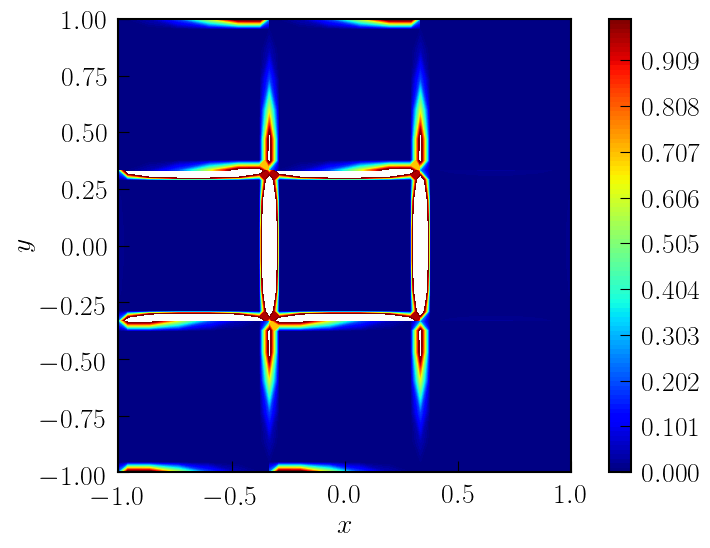

arrayfire.Array()
Type: double

[64 1 1 1]
    0.0010 
    0.0008 
    0.0005 
    0.0002 
    0.0001 
    0.0000 
    0.0000 
    0.0000 
    0.0016 
    0.0013 
    0.0008 
    0.0004 
    0.0001 
    0.0000 
    0.0000 
    0.0000 
    0.0047 
    0.0039 
    0.0024 
    0.0010 
    0.0003 
    0.0001 
    0.0000 
    0.0000 
    0.0168 
    0.0139 
    0.0085 
    0.0036 
    0.0011 
    0.0003 
    0.0001 
    0.0001 
    0.0539 
    0.0446 
    0.0272 
    0.0116 
    0.0036 
    0.0010 
    0.0004 
    0.0002 
    0.1260 
    0.1042 
    0.0636 
    0.0272 
    0.0085 
    0.0024 
    0.0008 
    0.0005 
    0.2063 
    0.1707 
    0.1042 
    0.0446 
    0.0139 
    0.0039 
    0.0013 
    0.0008 
    0.2494 
    0.2063 
    0.1260 
    0.0539 
    0.0168 
    0.0047 
    0.0016 
    0.0010 




In [38]:
plt.contourf(np.array(X[0]), np.array(Y[0]), np.array(af.moddims(surface_term_total[:, 0], N_LGL, N_LGL)), 200, levels = color_levels, cmap = 'jet')
plt.contourf(np.array(X[1]), np.array(Y[1]), np.array(af.moddims(surface_term_total[:, 1], N_LGL, N_LGL)), 200, levels = color_levels, cmap = 'jet')
plt.contourf(np.array(X[2]), np.array(Y[2]), np.array(af.moddims(surface_term_total[:, 2], N_LGL, N_LGL)), 200, levels = color_levels, cmap = 'jet')
plt.contourf(np.array(X[3]), np.array(Y[3]), np.array(af.moddims(surface_term_total[:, 3], N_LGL, N_LGL)), 200, levels = color_levels, cmap = 'jet')
plt.contourf(np.array(X[4]), np.array(Y[4]), np.array(af.moddims(surface_term_total[:, 4], N_LGL, N_LGL)), 200, levels = color_levels, cmap = 'jet')
plt.contourf(np.array(X[5]), np.array(Y[5]), np.array(af.moddims(surface_term_total[:, 5], N_LGL, N_LGL)), 200, levels = color_levels, cmap = 'jet')
plt.contourf(np.array(X[6]), np.array(Y[6]), np.array(af.moddims(surface_term_total[:, 6], N_LGL, N_LGL)), 200, levels = color_levels, cmap = 'jet')
plt.contourf(np.array(X[7]), np.array(Y[7]), np.array(af.moddims(surface_term_total[:, 7], N_LGL, N_LGL)), 200, levels = color_levels, cmap = 'jet')
plt.contourf(np.array(X[8]), np.array(Y[8]), np.array(af.moddims(surface_term_total[:, 8], N_LGL, N_LGL)), 200, levels = color_levels, cmap = 'jet')

plt.axes().set_aspect('equal')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.colorbar()

# plt.savefig('u_init.png')
plt.show()
print(u_init[0])

In [39]:
print(u_af_grid[0])

arrayfire.Array()
Type: double

[1 3 8 8]
    0.0010     0.2494     0.2494 

    0.0008     0.2063     0.2063 

    0.0005     0.1260     0.1260 

    0.0002     0.0539     0.0539 

    0.0001     0.0168     0.0168 

    0.0000     0.0047     0.0047 

    0.0000     0.0016     0.0016 

    0.0000     0.0010     0.0010 


    0.0016     0.2946     0.2063 

    0.0013     0.2437     0.1707 

    0.0008     0.1488     0.1042 

    0.0004     0.0636     0.0446 

    0.0001     0.0199     0.0139 

    0.0000     0.0056     0.0039 

    0.0000     0.0019     0.0013 

    0.0000     0.0011     0.0008 


    0.0047     0.3916     0.1260 

    0.0039     0.3240     0.1042 

    0.0024     0.1978     0.0636 

    0.0010     0.0846     0.0272 

    0.0003     0.0264     0.0085 

    0.0001     0.0074     0.0024 

    0.0000     0.0026     0.0008 

    0.0000     0.0015     0.0005 


    0.0168     0.4844     0.0539 

    0.0139     0.4007     0.0446 

    0.0085     0.2447     0.0272 

    0.0036